<font color='green'>Welcome everyone and thanks for attending !!</font> 

 


# Be a geoscience detective !


Repo at: https://github.com/mycarta/Be-a-geoscience-detective

### Objective
- <font color='darkblue'>Rigorously validate (or challenge) claims from a paper on geophysical inversion
    
    This is my "Data Science meets Repro Zoo"</font> 

### Punchline
J. Clarebout, as quoted in Sergey Fomel's Reproducible research ([52 things Geocomputing chapter](https://github.com/softwareunderground/52things/blob/master/chapters/Fomel.md)):

<font color='green'>"__...illustrations in a technical document are made by programs and command scripts that along with required data should be linked to the document itself"__</font> 

### Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import gridspec
import numpy as np
import scipy as sp
from scipy import interpolate
from itertools import groupby
import seaborn as sns
from skimage import io

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

###  Load example data: acustic impedance from inversion paper

I will now use the error flag function to evaluate the quality of seismic inversion form a published article in the November 2009 CSEG Recorder [Inversion Driven Processing](https://csegrecorder.com/articles/view/inversion-driven-processing).  In the article, the evaluation was done by the authors at a blind well location, but only qualitatively, as illustrated in Figure 5, shown below for reference.  In the top panel (a) the evaluation is for the inversion without SPNA (Signal Protected Noise Attenuation); in the bottom panel (b) for the inversion with SPNA.  On the right side of each panel the inverted seismic trace is plotted against the upscaled impedance well log (calculated by multiplying the well density log and the well velocity log from compressional sonic); on the right, the upscaled impedance log is inserted in a seismic impedance section as a colored trace (at the location of the well) using the same color scale and range used for the impedance section.

In [3]:
url = 'https://csegrecorder.com/assets/images/articles/2009-11-inversion-driven-fig05.jpg'
fig05=io.imread(url)

#### Figure 5 from an article in the November 2009 CSEG Recorder (Inversion Driven Processing)

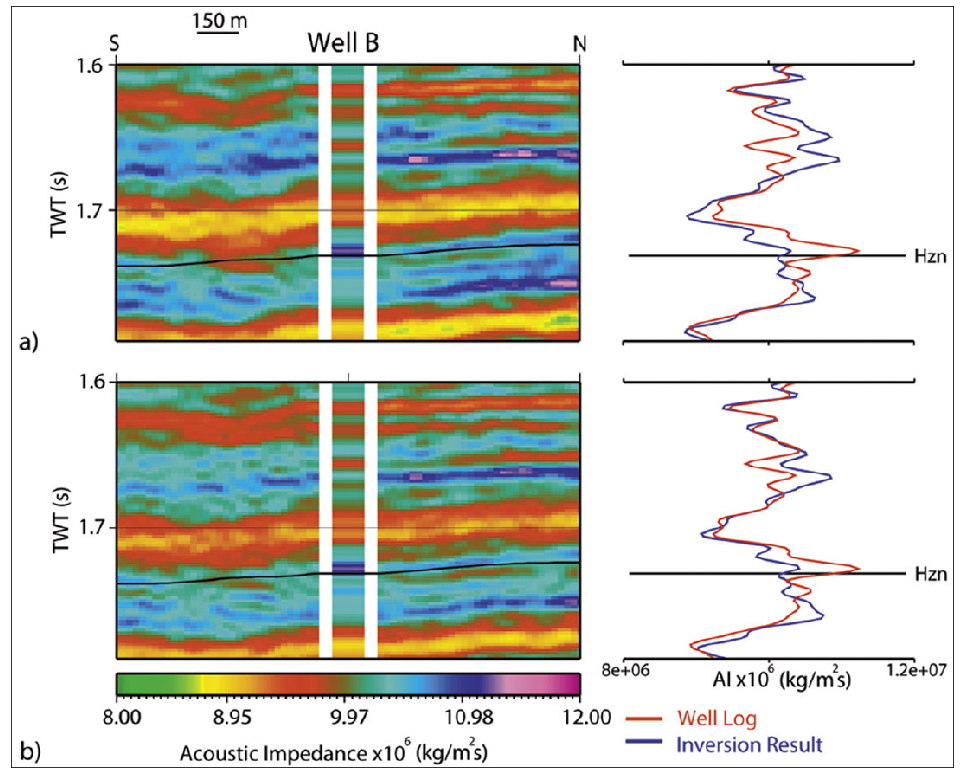

In [4]:
fig = plt.figure(figsize=(20, 14)); 
ax = fig.add_subplot(1, 1, 1); ax.set_xticks([]); ax.set_yticks([]); 
plt.imshow(fig05); 

__From the figure caption__: Acoustic impedance results at the blind well for data without (a) and with (b) Signal Protected Noise Attenuation(SPNA).<font color='cyan'> The data with SPNA</font> <font color='darkblue'> [bottom right]</font> <font color='cyan'> shows a better fit to the well, particularly over the low frequencies</font>. 

<font color='magenta'>That is the extent of the evaluation in the paper, unfortunately not backed by comparing a score, such as R^2, for the two methods</font>.

### Take the data out of the figure....

I hand-digitized and regularized the logs and inversion traces, and the horizon location, from the figure.

__To digitize plots/graphs (and run some tests on the data, or re-plot) - use WebPlotDigitizer: https://apps.automeris.io/wpd/__

#### Add logs and traces

In [5]:
log_a = np.loadtxt('data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,1]
log_a_t = np.loadtxt('data/Recorder09_upscaled_log_a.csv', delimiter=',')[:,0]

In [6]:
log_b = np.loadtxt('data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,1]
log_b_t = np.loadtxt('data/Recorder09_upscaled_log_b.csv', delimiter=',')[:,0]

In [7]:
inv_a = np.loadtxt('data/Recorder09_inversion_a.csv', delimiter=',')[:,1]
inv_a_t = np.loadtxt('data/Recorder09_inversion_a.csv', delimiter=',')[:,0]

In [8]:
inv_b = np.loadtxt('data/Recorder09_inversion_b.csv', delimiter=',')[:,1]
inv_b_t = np.loadtxt('data/Recorder09_inversion_b.csv', delimiter=',')[:,0]

In [9]:
fina = interpolate.interp1d(inv_a_t, inv_a)
finb = interpolate.interp1d(inv_b_t, inv_b)
floa = interpolate.interp1d(log_a_t, log_a)
flob = interpolate.interp1d(log_b_t, log_b)

time = np.arange(1.604, 1.8, 0.002)

ina = fina(time)
inb = finb(time)
loa = floa(time)
lob = flob(time)

In [10]:
result_a = pd.DataFrame({'time': time, 'inv': ina, 'log': loa})
result_b = pd.DataFrame({'time': time, 'inv': inb, 'log': lob})

In [11]:
result_a.head()  # inversion without SPNA (Signal Protected Noise Attenuation)

,time,inv,log
0,1.604,10.084,10.180000
1,1.606,10.287,10.220500
2,1.608,10.448,10.261000
3,1.610,10.502,10.257000
4,1.612,10.314,10.113667


#### Add the horizon

In [12]:
hrzn = np.genfromtxt('data/Recorder09_tops.csv', delimiter=',')[0, 1]

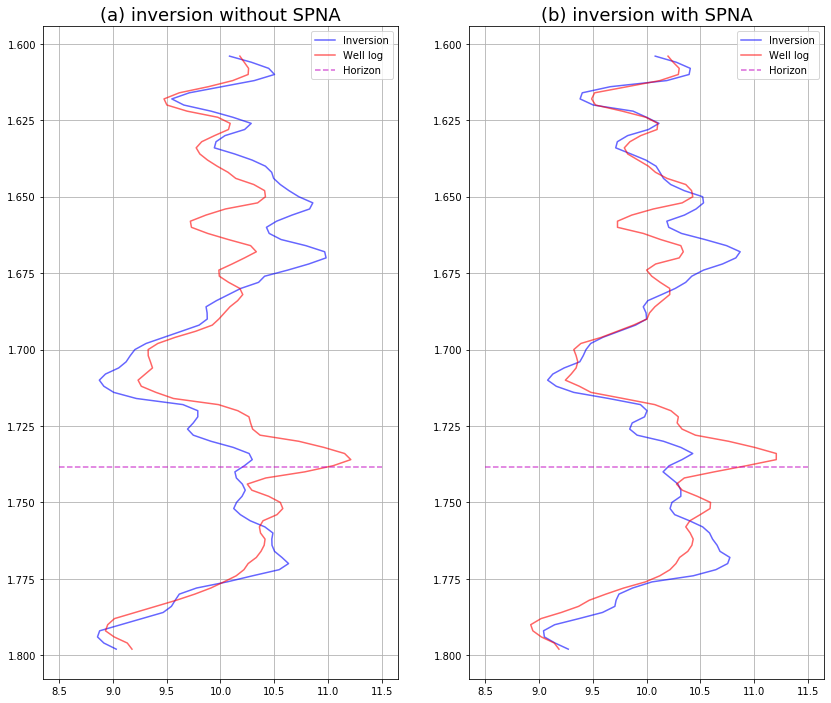

In [13]:
fig = plt.figure(figsize=(14,12))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.inv,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.log,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax1.invert_yaxis()
ax1.grid()
ax1.legend()
ax1.set_title('(a) inversion without SPNA', fontsize = 18)

ax2 = fig.add_subplot(122)
ax2.plot(result_b.inv,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.log,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax2.invert_yaxis()
ax2.grid()
ax2.legend()
ax2.set_title('(b) inversion with SPNA', fontsize = 18);

I hand-digitized the logs, inversion traces, and the horizon location (you can use the free [WebPlotDigitizer](https://apps.automeris.io/wpd/) ).

To do my evaluation in an upper and lower zone, I added an arbitrary geologic top, where I see a sharp increase in impedance.

In [14]:
fake_top = 1.715

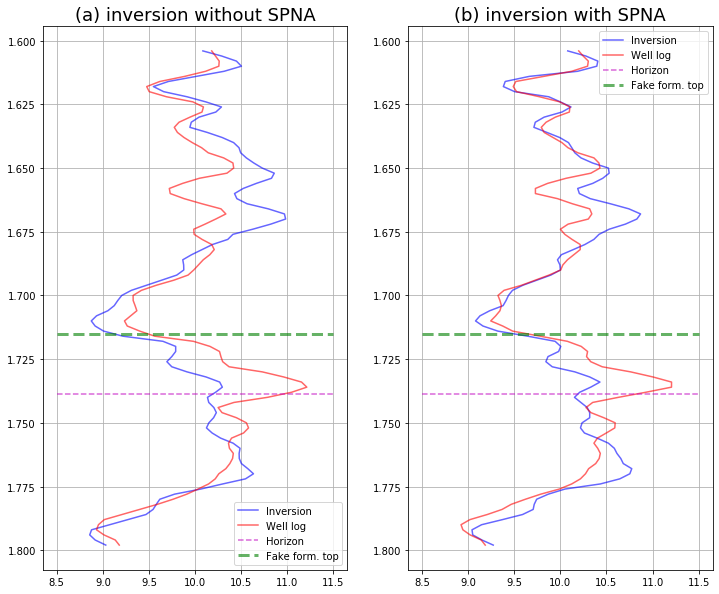

In [15]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.inv,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.log,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax1.plot([8.5, 11.5], [1.715, 1.715], 'g--', linewidth = 3, alpha = 0.6, label = 'Fake form. top')
ax1.invert_yaxis()
ax1.grid(); ax1.legend(); ax1.set_title('(a) inversion without SPNA', fontsize = 18)
ax2 = fig.add_subplot(122)
ax2.plot(result_b.inv,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.log,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [hrzn, hrzn], 'm--', alpha = 0.6, label = 'Horizon')
ax2.plot([8.5, 11.5], [fake_top, fake_top], 'g--', linewidth = 3, alpha = 0.6, label = 'Fake form. top')
ax2.invert_yaxis(); ax2.grid(); ax2.legend(); ax2.set_title('(b) inversion with SPNA', fontsize = 18);

### Comparing results of inversion with and without SPNA
I use the fake top to make an upper zone and a lower zone:

In [16]:
result_a['zone']= 'Upper'
result_a.loc[result_a.time >fake_top, 'zone'] = 'Lower'
result_b['zone']= 'Upper'
result_b.loc[result_b.time >fake_top, 'zone'] = 'Lower'

Let's check some of the top and bottom rows from this DataFrame:

In [17]:
pd.concat([result_a.head(3), result_a.tail(3)])

,time,inv,log,zone
0,1.604,10.084,10.180000,Upper
1,1.606,10.287,10.220500,Upper
2,1.608,10.448,10.261000,Upper
95,1.794,8.857,9.011500,Lower
96,1.796,8.916,9.134000,Lower
97,1.798,9.031,9.177333,Lower


#### Method 1: calculate the RMS error by zone

In [18]:
def rmse(dtf):
    """
    function to calculate the Root Mean Square Error 
    between log and inversion columns
    """
    x = dtf.log
    y = dtf.inv
    return pd.Series({'RMSE' : np.sqrt(np.mean((x-y)**2))})

In [19]:
zone_errors_a = result_a.groupby('zone', sort=False).apply(rmse).reset_index()
zone_errors_b = result_b.groupby('zone', sort=False).apply(rmse).reset_index()

In [20]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str = html_str + df.name + df.to_html(index=False)
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

I modified a short utility function (from [this SO answer](https://stackoverflow.com/a/44923103/1034648)) to display the result for the two methods side by side, with the name of the method added (based on [this other SO answer](https://stackoverflow.com/a/31727504/1034648)).

In [21]:
zone_errors_a.name = 'Without SPNA  '
zone_errors_b.name = 'With SPNA  '

display_side_by_side(zone_errors_a, zone_errors_b)

zone,RMSE
Upper,0.375958
Lower,0.409672
zone,RMSE
Upper,0.237558
Lower,0.368419


Based on the RMS error, it looks like case b (on the right), the inversion with Signal Protected Noise Attenuated applied on the data is a better result for the `Upper` zone, but not for the `Lower` one. This result is in agreement with my visual comparison of the two methods.__

### Method 2: using error flag

### New version of my function to make error flags

I updated the `error_flag` function below in three ways:

- Users now can choose between mean/standard deviation and median/[median absolute deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) as a statistic for the error. The latter is more robust in the presence of outliers.
- Added a convolutional smoother prior to the slope calculation, so as to make it less sensitive to noisy samples
- Expanded and improved the doctstring

In [22]:
def error_flag(pred, actual, stat, dev = 1.0, method = 1):
    """Calculate the difference between a predicted and an actual curve and return a curve flagging large 
    differences based on a user-defined distance (in deviation units) from either the mean difference or
    the median difference.     
    Matteo Niccoli, October 2018. Updated in May 2020.
  
  Parameters:
        predicted : array
            predicted log array          
        actual : array
            original log array           
        stat : {‘mean’, ‘median’}
            The statistics to use. The following options are available:
                - mean: uses numpy.mean for the statistic, 
                and np.std for dev calculation
                - median: uses numpy.median for the statistic, 
                and scipy.stats.median_absolute_deviation (MAD) for dev calculation       
        dev : float, optional
            the standard deviations to use. The default is 1.0           
        method : int {1, 2, 3}, optional
            The error method to use. The following options are available
            (default is 1):
                1: difference between curves larger than mean difference plus dev
                2: curve slopes have opposite sign (after a 3-sample window smoothing)
                3: curve slopes of opposite sign OR difference larger than mean plus dev  
    Returns:
        flag : array
        The error flag array
    """      
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    
    if stat == 'mean':
        err_stat = np.mean(err)
        err_dev = np.std(err)
    elif stat == 'median':
        err_stat = np.median(err)
        err_dev = sp.stats.median_absolute_deviation(err)
        
    pred_sm = pd.Series(np.convolve(pred, np.ones(3), 'same'))
    actual_sm = pd.Series(np.convolve(actual, np.ones(3), 'same'))
    ss = np.sign(pred_sm.diff().fillna(pred_sm))
    ls = np.sign(actual_sm.diff().fillna(actual_sm))                  

    if method == 1:
        flag[np.where(err>(err_stat + (dev*err_dev)))] = 1
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_stat + (dev*err_dev)), (ss+ls)==0 ))]= 1
    return flag

In [23]:
result_a['flag']= error_flag(result_a.inv, result_a.log, 'median', 0.5, 3)
result_b['flag']= error_flag(result_b.inv, result_b.log, 'median', 0.5, 3)

#### I use my own `error_flag` function (not shown) to:
- calculate the difference between the log and the inversion prediction at every sample
- calculate the median difference and the median absolute deviation  (MAD)
- use a MAD of 0.5 to trigger a prediction error flag

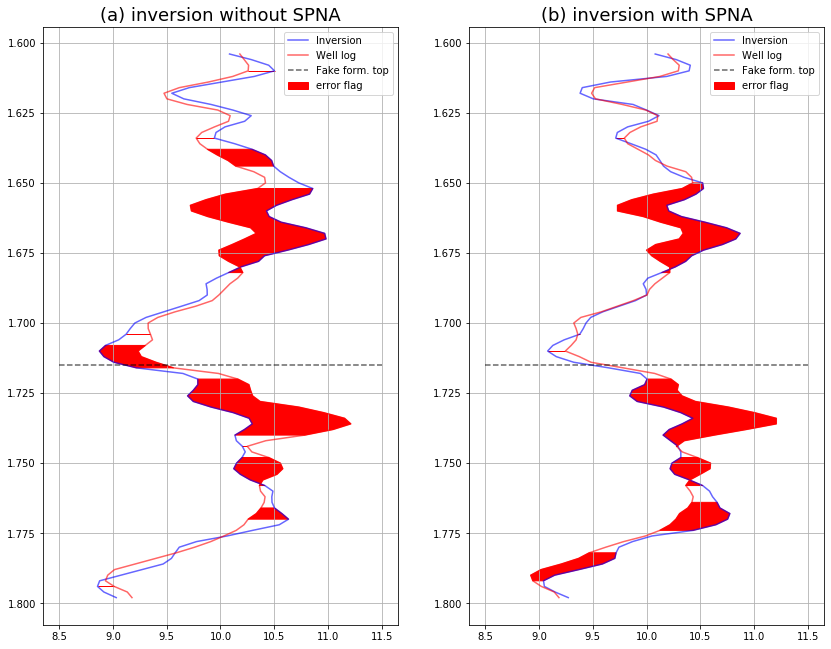

In [24]:
fig = plt.figure(figsize=(14,11))
ax1 = fig.add_subplot(121)
ax1.plot(result_a.inv,result_a.time,'b', alpha = 0.6, label = 'Inversion')
ax1.plot(result_a.log,result_a.time,'r', alpha = 0.6, label = 'Well log')
ax1.plot([8.5, 11.5], [fake_top, fake_top], 'k--', alpha = 0.6, label = 'Fake form. top')
ax1.fill_betweenx(result_a.time, result_a.inv, result_a.log, where=result_a['flag']==1, color = 'r', label='error flag')
ax1.invert_yaxis(); ax1.grid(); ax1.legend(); ax1.set_title('(a) inversion without SPNA', fontsize = 18)
ax2 = fig.add_subplot(122)
ax2.plot(result_b.inv,result_b.time,'b', alpha = 0.6, label = 'Inversion')
ax2.plot(result_b.log,result_b.time,'r', alpha = 0.6, label = 'Well log')
ax2.plot([8.5, 11.5], [fake_top, fake_top], 'k--', alpha = 0.6, label = 'Fake form. top')
ax2.fill_betweenx(result_b.time, result_b.inv, result_b.log, where=result_b['flag']==1, color = 'r', label='error flag')
ax2.invert_yaxis(); ax2.grid(); ax2.legend(); ax2.set_title('(b) inversion with SPNA', fontsize = 18);

#### Count the number and percentage of samples that have been flagged for each result

In [25]:
zone_errors_a['flagged samples'] =  result_a.groupby('zone', sort=False).flag.sum().values
zone_errors_b['flagged samples'] =  result_b.groupby('zone', sort=False).flag.sum().values


# This is a lot more panda-ish than:
# zone_errors_b['flagged samples'] =  [result_b.loc[result_b.zone == z,  'flag'].sum() for z in zones_b]

In [26]:
def calc_proportion(dtf):
    """
    function to calculate proportion of flagged samples
    """
    x = dtf.flag
    return round(100 * x.sum()/len(x), 1)

In [27]:
zone_errors_a = zone_errors_a.drop(['RMSE'], axis = 1)
zone_errors_b = zone_errors_b.drop(['RMSE'], axis = 1)

zone_errors_a.name = 'Without SPNA  '
zone_errors_b.name = 'With SPNA  '

In [28]:
zone_errors_a['proportion (%)'] =  result_a.groupby('zone', sort=False).apply(calc_proportion).values
zone_errors_b['proportion (%)'] =  result_b.groupby('zone', sort=False).apply(calc_proportion).values

In [29]:
display_side_by_side(zone_errors_a, zone_errors_b)

zone,flagged samples,proportion (%)
Upper,27.0,48.2
Lower,23.0,54.8
zone,flagged samples,proportion (%)
Upper,20.0,35.7
Lower,31.0,73.8


<font color='darkgreen'>The error flag method is in agreement with visual intuition: case b, the inversion on Singal Protected Noise Attenuated data is a better result for the `Upper` zone, but for the `Lower` zone the inversion without SPNA is better.</font>

### Diving deeper still

But can we be confident about those two "is better" above in the same way?

This can be answered by creating a bootstrapped Confidence Interval for the proportions of flagged samples

#### Create data tables

I first create [tables from the DataFrames](http://data8.org/datascience/_autosummary/datascience.tables.Table.from_df.html#datascience.tables.Table.from_df). Tables are [sequences of labeled columns of data](http://data8.org/datascience/tables.html#tables-overview).

In [30]:
from datascience import Table

In [31]:
result_a_bool = result_a.copy()
result_a_bool.flag=result_a_bool.flag.astype('bool') 

result_b_bool = result_b.copy()
result_b_bool.flag=result_b_bool.flag.astype('bool') 

In [32]:
table_a = Table.from_df(result_a_bool)
table_a

time,inv,log,zone,flag
1.604,10.084,10.18,Upper,False
1.606,10.287,10.2205,Upper,False
1.608,10.448,10.261,Upper,False
1.61,10.502,10.257,Upper,True
1.612,10.314,10.1137,Upper,False
1.614,10.012,9.887,Upper,False
1.616,9.71,9.617,Upper,False
1.618,9.5475,9.475,Upper,False
1.62,9.659,9.502,Upper,False
1.622,9.912,9.68967,Upper,False


In [33]:
table_b = Table.from_df(result_b_bool)
table_b

time,inv,log,zone,flag
1.604,10.08,10.199,Upper,False
1.606,10.276,10.247,Upper,False
1.608,10.406,10.303,Upper,False
1.61,10.395,10.295,Upper,False
1.612,10.1875,10.123,Upper,False
1.614,9.663,9.82,Upper,False
1.616,9.402,9.517,Upper,False
1.618,9.382,9.489,Upper,False
1.62,9.50467,9.525,Upper,False
1.622,9.874,9.774,Upper,False


#### Create the two bootstaps and confidence intervals for case a (without SPNA) and b (with SPNA)

In [34]:
from datascience import make_array, percentile

In [35]:
def bootstrap_proportion(original_sample, label, replications):
    
    """
    Return an array of bootstrapped sample proportions:
    original_sample: table containing the original sample
    label: label of column containing the Boolean variable
    replications: number of bootstrap samples
    
    Source: https://www.inferentialthinking.com/chapters/13/3/Confidence_Intervals.html
    """
    
    just_one_column = original_sample.select(label)
    proportions = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resample_array = bootstrap_sample.column(0)
        resampled_proportion = np.count_nonzero(resample_array)/len(resample_array)
        proportions = np.append(proportions, resampled_proportion)
        
    return np.around(proportions, 2) # modified to round to 2 decimals

In [36]:
zone_errors_a['CI_90_low'] = [percentile (5, bootstrap_proportion(table_a.where('zone', z), label='flag',replications=5000)) for z in ['Upper', 'Lower']]
zone_errors_a['CI_90_high'] = [percentile (95, bootstrap_proportion(table_a.where('zone', z), label='flag',replications=5000)) for z in ['Upper', 'Lower']]

In [37]:
zone_errors_b['CI_90_low']= [percentile (5, bootstrap_proportion(table_b.where('zone', z), label='flag',replications=5000)) for z in ['Upper', 'Lower']]
zone_errors_b['CI_90_high'] = [percentile (95, bootstrap_proportion(table_b.where('zone', z), label='flag',replications=5000)) for z in ['Upper', 'Lower']]

In [38]:
zone_errors_a.name = 'Without SPNA  '
zone_errors_b.name = 'With SPNA  '

In [39]:
display_side_by_side(zone_errors_a, zone_errors_b)

zone,flagged samples,proportion (%),CI_90_low,CI_90_high
Upper,27.0,48.2,0.38,0.59
Lower,23.0,54.8,0.43,0.67
zone,flagged samples,proportion (%),CI_90_low,CI_90_high
Upper,20.0,35.7,0.25,0.46
Lower,31.0,73.8,0.62,0.83


__I am really excited this worked, but I do really believe that an image is better than a thousand words, so I put in a bit more work to show the distributions.__

#### Histograms

In [40]:
bootstrap_upper=Table(['No SPNA', 'SPNA'])
bootstrap_upper['No SPNA']=bootstrap_proportion(table_a.where('zone', 'Upper'), 'flag', 20000)
bootstrap_upper['SPNA']=bootstrap_proportion(table_b.where('zone', 'Upper'), 'flag', 20000)

In [41]:
bootstrap_lower=Table(['No SPNA', 'SPNA'])
bootstrap_lower['No SPNA']=bootstrap_proportion(table_a.where('zone', 'Lower'), 'flag', 20000)
bootstrap_lower['SPNA']=bootstrap_proportion(table_b.where('zone', 'Lower'), 'flag', 20000)

__The next two plots show, for the `Upper` and `Lower` zone, respectively, the distribution of bootstrap flagged proportions for the two inversion results.__

I used the [datascience library](http://data8.org/datascience/tutorial.html) from data8.org to create 20,000 bootstrap samples

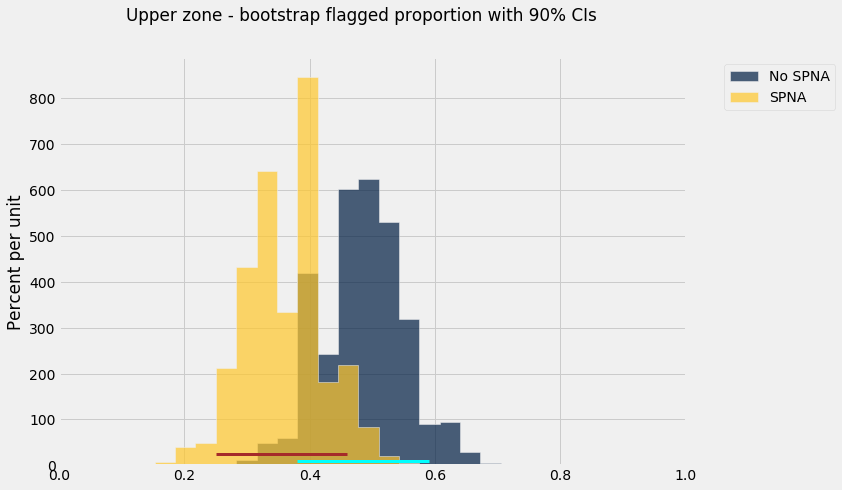

In [42]:
plt.style.use('fivethirtyeight')
bootstrap_upper.select(['No SPNA','SPNA']).hist(overlay=True,bins=20,normed=True)
plt.plot(make_array(zone_errors_a['CI_90_low'][0], zone_errors_a['CI_90_high'][0]), make_array(0.1, 0.1), 
color='cyan', lw=3);
plt.plot(make_array(zone_errors_b['CI_90_low'][0], zone_errors_b['CI_90_high'][0]), make_array(0.25, 0.25), 
         color='brown', lw=3);
plt.xlim(0, 1); fig = plt.gcf(); fig.set_size_inches(10,7)
fig.suptitle('Upper zone - bootstrap flagged proportion with 90% CIs');

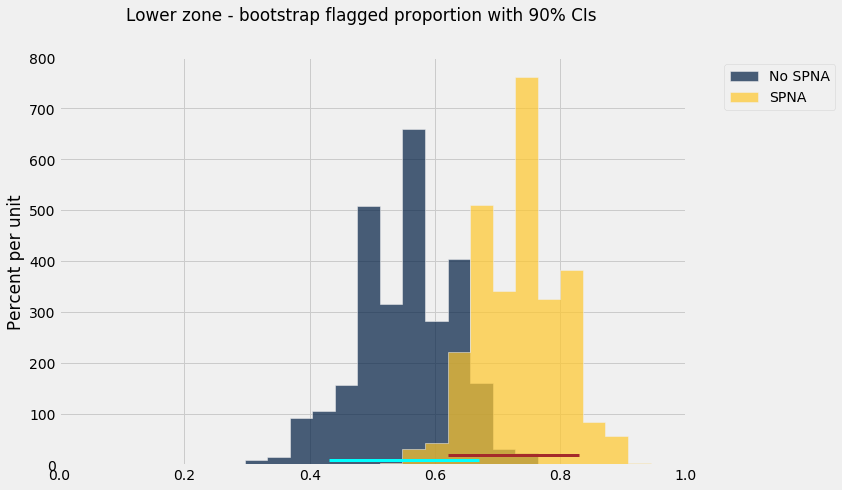

In [43]:
plt.style.use('fivethirtyeight')
bootstrap_lower.select(['No SPNA','SPNA']).hist(overlay=True,bins=20,normed=True)
plt.plot(make_array(zone_errors_a['CI_90_low'][1], zone_errors_a['CI_90_high'][1]), make_array(0.1, 0.1), 
         color='cyan', lw=3);
plt.plot(make_array(zone_errors_b['CI_90_low'][1], zone_errors_b['CI_90_high'][1]), make_array(0.2, 0.2), 
         color='brown', lw=3);
plt.xlim(0, 1); fig = plt.gcf(); fig.set_size_inches(10,7)
fig.suptitle('Lower zone - bootstrap flagged proportion with 90% CIs');

### License
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />The code in this work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"> CC BY Creative Commons License</a>.

The figure used is copyright of the Canadian Society of Exploration Geophysicists.